# Ch 15 Recurrent neural networks

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Generate dataset

In [4]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1)) * (freq1 * 10 + 10)   # wave 1
    series += 0.2 * np.sin((time - offsets2)) * (freq2 * 20 + 20)  # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)    # noise

    return series[..., np.newaxis].astype(np.float32)

In [5]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


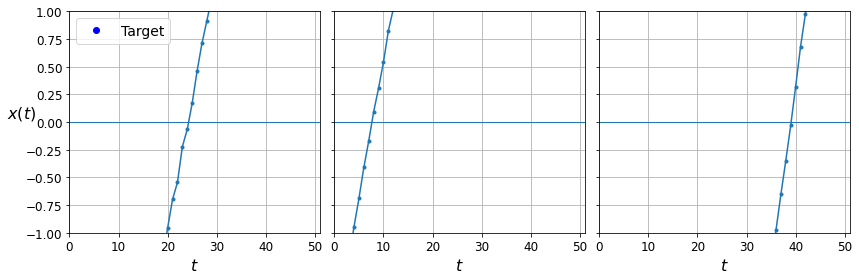

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

### Baseline metrics

First let's do naive forecasting just by predicting the last value:

In [8]:
y_pred = X_valid[:, -1]
np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-23 16:33:08.989451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-23 16:33:08.989569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0.055242274

Another approach is to use a linear model:

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50, 1)),
    tf.keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


2022-06-23 16:33:09.078479: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/219 [..............................] - ETA: 38s - loss: 5.5337

2022-06-23 16:33:09.203122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 1s 4ms/step - loss: 0.1957 - val_loss: 0.0023
Epoch 2/20
  1/219 [..............................] - ETA: 0s - loss: 0.0015

2022-06-23 16:33:10.077812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 11/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 12/

In [10]:
y_pred = model.predict(X_valid)
np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred))

63/63 [==============================] - 0s 1ms/step


2022-06-23 16:33:29.020062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.002648041

For some strange reason, I get different results that is provided by Geron in the notebooks on github (I use the same random seeds, of course).
However, the average prediction error for the naive forcasting is 0.055 (0.02021 in the book) and for linear model is 0.0026 (0.004 in the book).

### Simple RNN

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1]),
])

model.compile(loss="mse", optimizer="adam")
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

NameError: name 'x_train' is not defined